# Импорт

Импортируем все необходимые библиотеки и подключаем диск для доступа к файлам с обучающими данными

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.layers import *
from keras.models import Model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import plot_model
from keras.models import load_model
from keras.optimizers import *

import numpy as np

import cv2
from PIL import Image
from PIL import ImageOps
from google.colab.patches import cv2_imshow

import os
import csv
import pandas as pd
import zipfile

import matplotlib.pyplot as plt
import math


# Предобработка данных

Задаются константы для количества элементов обучающего набора и размера изображения

In [ ]:
N_TRAIN = 40000
IMAGE_SIZE = 128

Создается функция, изменяющая размер изображения к одному для всей выборки

In [ ]:
def resize(img, shape_to=(IMAGE_SIZE, IMAGE_SIZE)):
    if img.shape[0] > shape_to[0] or img.shape[1] > shape_to[1]:
        shrink_multiplayer = min(math.floor(shape_to[0] / img.shape[0] * 100) / 100,
                                 math.floor(shape_to[1] / img.shape[1] * 100) / 100)
        img = cv2.resize(img, None,
                         fx=shrink_multiplayer,
                         fy=shrink_multiplayer,
                         interpolation=cv2.INTER_AREA)

    img = cv2.copyMakeBorder(img, math.ceil(shape_to[0]/2) - math.ceil(img.shape[0]/2),
                             math.floor(shape_to[0]/2) - math.floor(img.shape[0]/2),
                             math.ceil(shape_to[1]/2) - math.ceil(img.shape[1]/2),
                             math.floor(shape_to[1]/2) - math.floor(img.shape[1]/2),
                             cv2.BORDER_CONSTANT, value=(255, 255, 255))
    return img

Выгружаются из архива данные обучающего набора и дополняются изображения в представлении в виде массива пикселей в формате RGB и приводятся к одному размеру: 256х64х3

In [ ]:
zf = zipfile.ZipFile('/content/drive/MyDrive/Task1/train.zip')
df = pd.read_csv(zf.open('train.csv'))

imgs = []
zf_imgs = zipfile.ZipFile('/content/drive/MyDrive/Task1/imgs.zip')
for n in df["name"].values[:N_TRAIN]:
    data = zf_imgs.read("imgs/"+n)
    img = cv2.imdecode(np.frombuffer(data, np.uint8), 1)
    img = cv2.resize(img, (256, 64))
    imgs.append(img)

df_img = pd.DataFrame({"img":imgs})
df = df.join(df_img)
df

text  \
0                                             постоянный   
1       другой флагманский мотор от Mercedes — 5,5-ли...   
2                 ию поправок в регламент, касающихся из   
3                                               менения.   
4            рганы без повестки отказалась. Учителя и ро   
...                                                  ...   
73366                                           подразд.   
73367                                              связи   
73368   этим дело не обошлось. Компанию постоянно ата...   
73369   цоперации. «Газете.Ru» в пресс-службе СУ СКП под   
73370                                              Армия   

                                        name  label  \
0       3957e9bc20e3449ba3cebb5c20c5d34a.png      1   
1      9938896eaed945a5bffe8b7b10e31d2e.jpeg      0   
2      de6f4e67b9f84f1aa51a87f689382b99.jpeg      0   
3      49112e7901214d2aa831568210876051.jpeg      0   
4      1e82d1d13eb344ef886caafb014a34d0.jpeg      0   
...                                      ...    ...   
73366   bad078ac1e964a0ea920a2e5dfbc2e68.png      1   
73367   c9eb57d6c3ce4bf2aeb0065ec1fd65df.png      1   
73368  c50d3fcfe8a843489bd9c6c1dacf4bb3.jpeg      0   
73369  962fc54dd5e646be964fc71f3a5ce017.jpeg      0   
73370   4f4c579a5fb34d079fc95d7df96edab0.png      1   

                                                     img  
0      [[[255, 255, 254], [255, 255, 254], [255, 255,...  
1      [[[184, 219, 232], [184, 219, 232], [184, 219,...  
2      [[[233, 239, 244], [233, 239, 244], [233, 239,...  
3      [[[255, 255, 255], [255, 255, 255], [255, 255,...  
4      [[[233, 239, 244], [233, 239, 244], [233, 239,...  
...                                                  ...  
73366                                                NaN  
73367                                                NaN  
73368                                                NaN  
73369                                                NaN  
73370                                                NaN  

[73371 rows x 4 columns]

Выводим одно из изображений

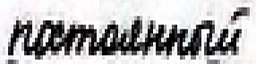

In [ ]:
cv2_imshow(imgs[0])

Выводим изображение в виде массива

In [ ]:
df["img"].values[0]

array([[[255, 255, 254],
        [255, 255, 254],
        [255, 255, 254],
        ...,
        [240, 239, 241],
        [240, 239, 241],
        [246, 245, 247]],

       [[255, 255, 254],
        [255, 255, 254],
        [255, 255, 254],
        ...,
        [238, 237, 239],
        [238, 237, 239],
        [245, 244, 246]],

       [[255, 255, 254],
        [255, 255, 254],
        [255, 255, 254],
        ...,
        [236, 235, 237],
        [237, 236, 238],
        [246, 245, 247]],

       ...,

       [[246, 244, 243],
        [245, 243, 243],
        [245, 243, 243],
        ...,
        [245, 247, 247],
        [244, 246, 247],
        [244, 246, 247]],

       [[247, 245, 244],
        [246, 244, 243],
        [248, 246, 246],
        ...,
        [246, 248, 248],
        [245, 247, 248],
        [245, 247, 248]],

       [[248, 246, 245],
        [247, 245, 244],
        [250, 248, 248],
        ...,
        [246, 248, 248],
        [246, 248, 249],
        [246, 248, 249]]

# Создание и обучение модели

Создается функция для создания модели

In [ ]:
def class_model():
  # Входящий слой
  inputs = Input(shape = (64, 256, 3))

  # Два упорядоченных сверточных слоя
  conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)

  # Слой получающий средний светочный слой
  pool1 = GlobalAveragePooling2D()(conv2)

  # Плотный слой для классификации
  dense1 = Dense(128,activation = "relu")(pool1)
  # Dropout для исключения части нейронов при обучении
  drop1 = Dropout(0.5)(dense1)
  # Выходной слой с значением от 0 до 1, указывающий на пренадлежность к классу
  output = Dense(1,activation = "sigmoid")(drop1)

  model = Model(inputs = inputs,outputs = output)

  model.compile(optimizer = "adam",loss = "binary_crossentropy",metrics = ["accuracy"])

  return model

Создание модели с заданием callback и ранней остановки. Вывод структуры модели

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 256, 3)]      0         
                                                                 
 conv2d (Conv2D)             (None, 64, 256, 32)       896       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 256, 64)       18496     
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                             

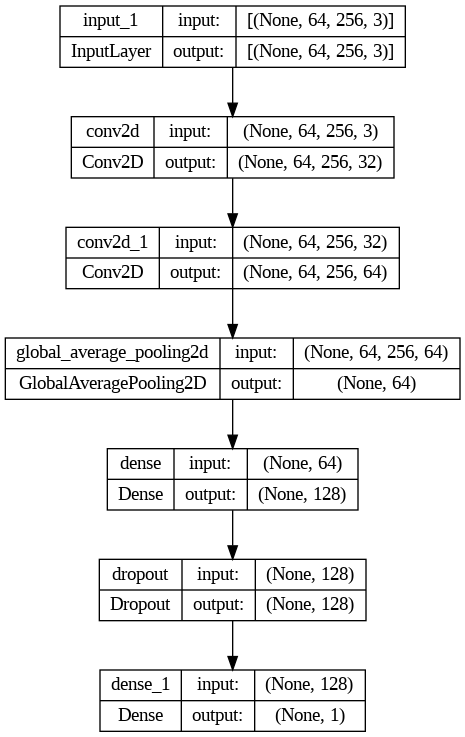

In [ ]:
model_save_path = "drive/MyDrive/Class1.h5"
callback = ModelCheckpoint(model_save_path,monitor="loss",save_best_only = True,verbose = 1)
earlystop = EarlyStopping(monitor = "accuracy",patience = 5)

model = class_model()

print(model.summary())

plot_model(model, 'my_first_model_with_shape_info.png', show_shapes=True)

Обучении модели на тренировочном наборе

In [ ]:
history = model.fit(np.stack(df["img"][:N_TRAIN], 0), df["label"][:N_TRAIN],
                    batch_size = 32,epochs = 10,
                    callbacks = [callback,earlystop])

Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 0.8855 - accuracy: 0.9616
Epoch 1: loss improved from inf to 0.88550, saving model to drive/MyDrive/Class1.h5
1250/1250 [==============================] - 52s 31ms/step - loss: 0.8855 - accuracy: 0.9616
Epoch 2/10
1249/1250 [============================>.] - ETA: 0s - loss: 0.0083 - accuracy: 0.9978
Epoch 2: loss improved from 0.88550 to 0.00831, saving model to drive/MyDrive/Class1.h5
1250/1250 [==============================] - 36s 29ms/step - loss: 0.0083 - accuracy: 0.9978
Epoch 3/10
1249/1250 [============================>.] - ETA: 0s - loss: 0.0077 - accuracy: 0.9979
Epoch 3: loss improved from 0.00831 to 0.00771, saving model to drive/MyDrive/Class1.h5
1250/1250 [==============================] - 36s 29ms/step - loss: 0.0077 - accuracy: 0.9979
Epoch 4/10
1249/1250 [============================>.] - ETA: 0s - loss: 0.0058 - accuracy: 0.9985
Epoch 4: loss improved from 0.00771 to 0.00579, saving model to drive

Построение графика характеристик обучения

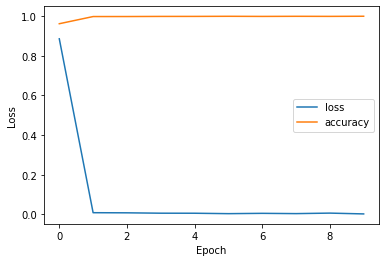

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Проверка на тестовом наборе

Загрузка лучшей модели в ходе обучения

In [ ]:
model = load_model("drive/MyDrive/Class1.h5")

Загрузка тестового набора и проверка работы модели на нем. Для каждого изображения получаем 4 поворота и делаем предсказания и если 4 раза было предсказан рукописный текст: текст рукописный, если 2 раза, то печатный, так как в повернутом на 90 градусов виде изображение всегда распознается, как рукописное из-за сжатия, при котором весь текст сливается в один неровный символ или пятно. Это позволяет предсказывать рукописный текст или печатный независимо от поворота изображения.

13/13 [==============================] - 0s 8ms/step


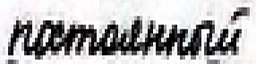

[1.]


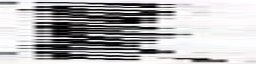

[1.]


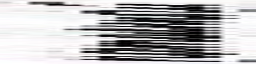

[1.]


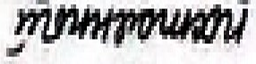

[1.]


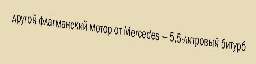

[2.988522e-07]


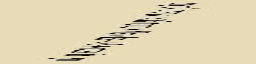

[0.15768845]


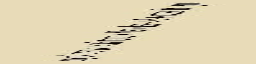

[0.06540047]


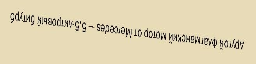

[1.1984653e-07]


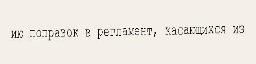

[0.00218895]


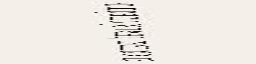

[0.00342882]


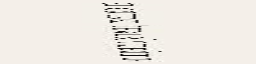

[0.00466073]


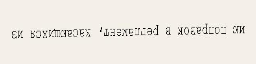

[0.00295251]


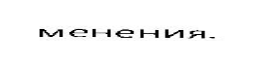

[0.93641585]


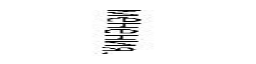

[0.00242523]


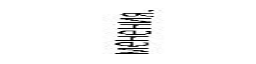

[0.00161897]


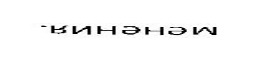

[0.96057695]


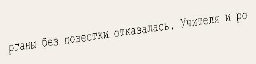

[0.00930796]


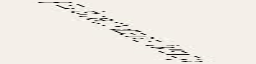

[0.00085348]


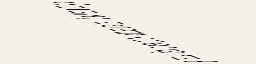

[0.00070676]


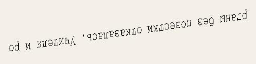

[0.01015657]


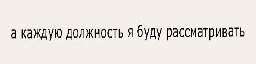

[0.00144312]


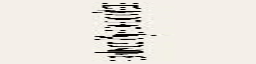

[0.7369599]


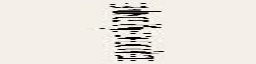

[0.4057872]


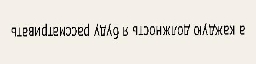

[0.00257383]


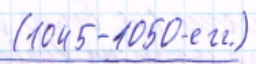

[1.]


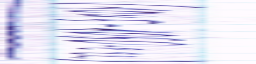

[0.9999999]


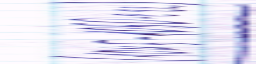

[0.9999994]


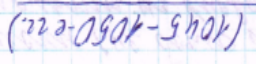

[1.]


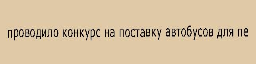

[7.453116e-07]


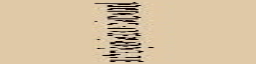

[0.02101738]


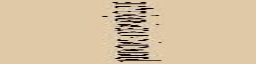

[0.04073235]


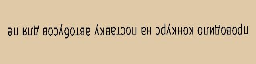

[2.70919e-07]


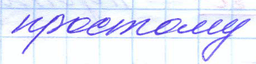

[1.]


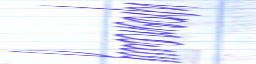

[1.]


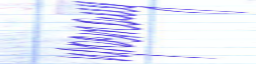

[1.]


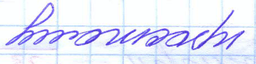

[1.]


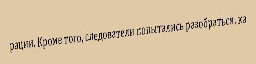

[1.0564846e-07]


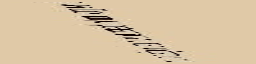

[0.00283584]


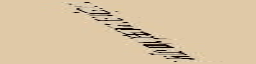

[0.00214143]


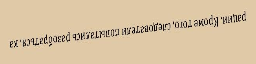

[1.633889e-07]


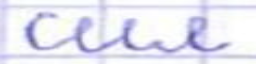

[0.999985]


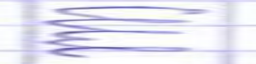

[0.9999989]


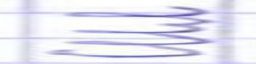

[0.9999987]


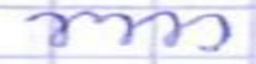

[0.99998486]


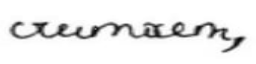

[1.]


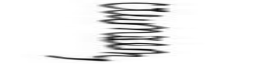

[0.9533131]


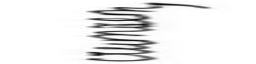

[0.95287496]


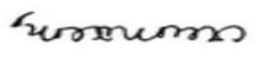

[1.]


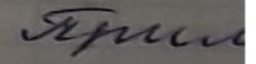

[1.]


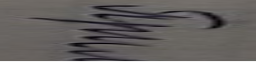

[1.]


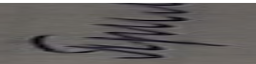

[0.9181337]


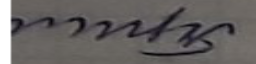

[0.9999999]


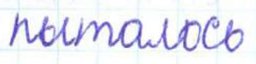

[1.]


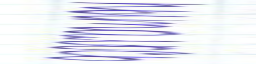

[1.]


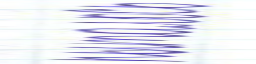

[1.]


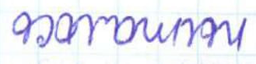

[1.]


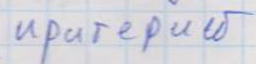

[0.9999752]


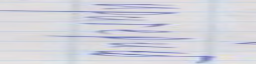

[0.9999225]


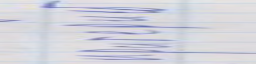

[0.9999311]


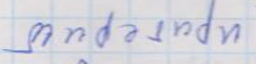

[0.99995697]


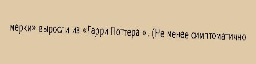

[4.1993917e-05]


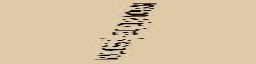

[0.12516111]


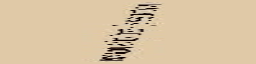

[0.14875895]


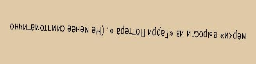

[2.1819867e-05]


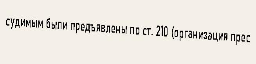

[6.0312465e-07]


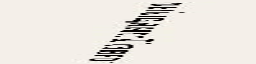

[0.9999912]


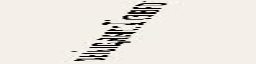

[0.9999856]


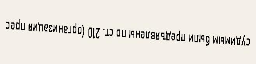

[2.664295e-06]


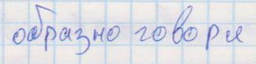

[0.9999962]


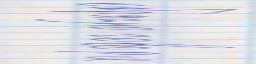

[0.9999349]


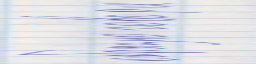

[0.99992967]


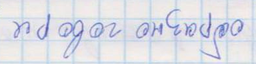

[0.9999938]


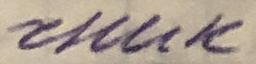

[1.]


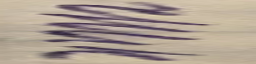

[0.99999964]


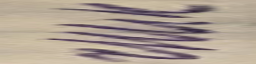

[0.9999999]


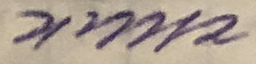

[1.]


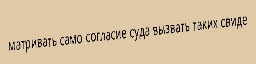

[6.1633064e-06]


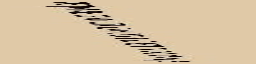

[0.00762545]


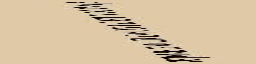

[0.00665313]


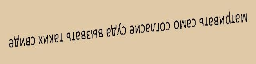

[2.8430702e-06]


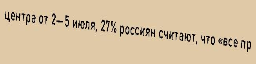

[0.00071266]


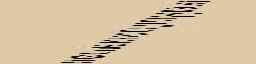

[0.00033033]


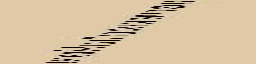

[0.00077254]


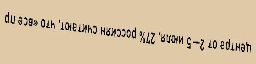

[0.0008679]


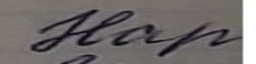

[1.]


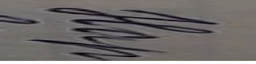

[1.]


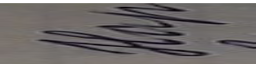

[0.99556386]


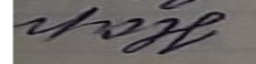

[1.]


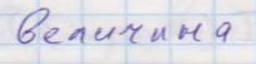

[0.9999994]


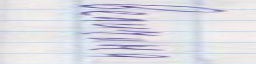

[0.99996924]


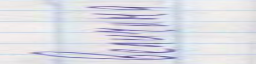

[0.999967]


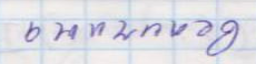

[0.99999976]


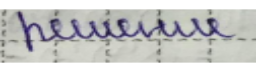

[1.]


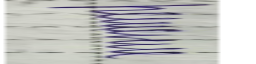

[0.9996138]


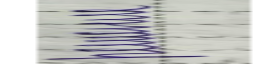

[0.99695575]


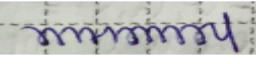

[1.]


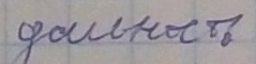

[0.99999833]


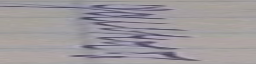

[0.9998066]


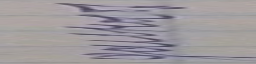

[0.99982387]


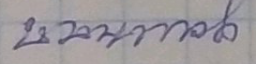

[0.9999993]


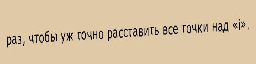

[7.178602e-05]


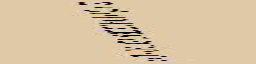

[1.07224305e-05]


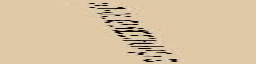

[7.98136e-06]


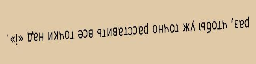

[3.7436024e-05]


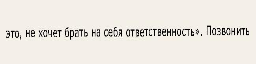

[1.1510041e-07]


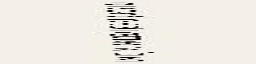

[0.00034369]


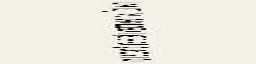

[0.00086276]


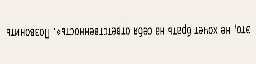

[2.7075862e-07]


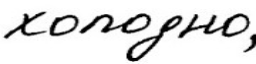

[1.]


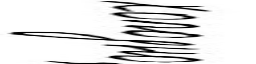

[0.01514154]


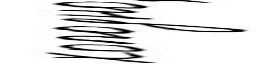

[0.28983793]


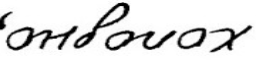

[1.]


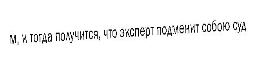

[7.413181e-06]


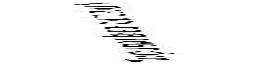

[0.00133845]


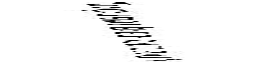

[0.00067437]


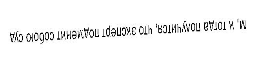

[1.3654036e-05]


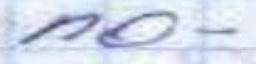

[0.99999774]


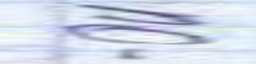

[0.9999969]


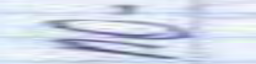

[0.9999968]


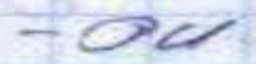

[0.99999595]


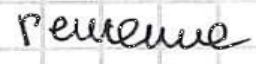

[1.]


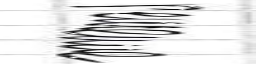

[5.5940956e-05]


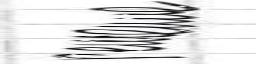

[0.00011565]


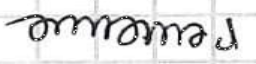

[1.]


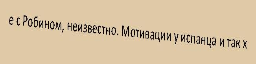

[2.4641804e-07]


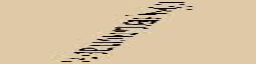

[0.00023705]


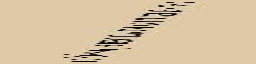

[0.00036131]


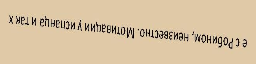

[1.3770475e-07]


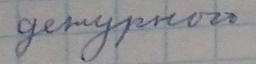

[0.9999032]


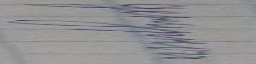

[0.9995628]


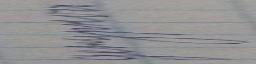

[0.9994875]


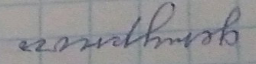

[0.9998306]


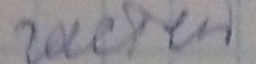

[0.9995372]


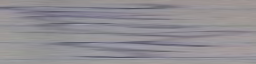

[0.99950564]


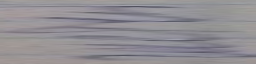

[0.9994093]


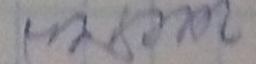

[0.99948716]


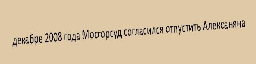

[1.1420224e-06]


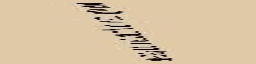

[0.04485843]


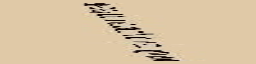

[0.01891074]


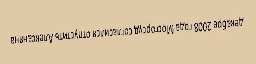

[9.470715e-07]


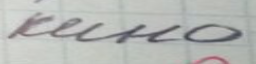

[0.9999893]


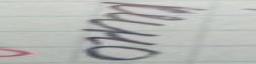

[0.9998894]


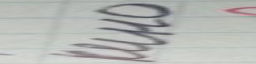

[0.9999521]


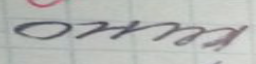

[0.99999464]


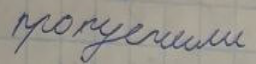

[0.9999995]


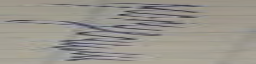

[0.99964654]


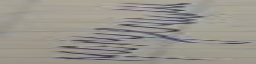

[0.99956876]


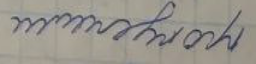

[0.99999833]


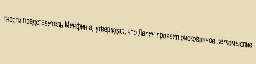

[0.00013032]


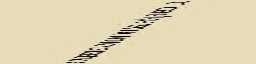

[0.09264137]


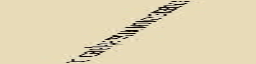

[0.11821094]


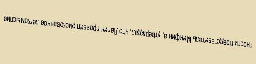

[0.00017303]


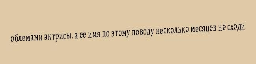

[9.293062e-06]


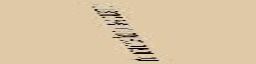

[0.05117373]


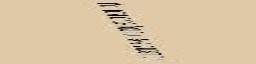

[0.03225471]


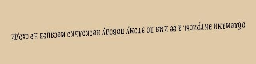

[1.13253855e-05]


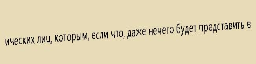

[8.653379e-07]


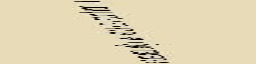

[0.00329392]


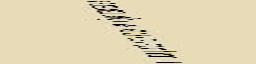

[0.00516051]


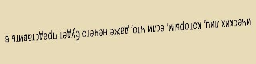

[9.447605e-07]


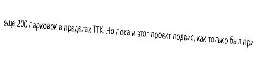

[0.00176302]


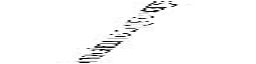

[0.07636505]


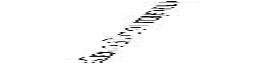

[0.16083285]


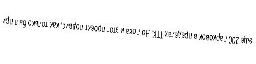

[0.00035724]


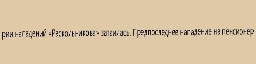

[4.7826194e-05]


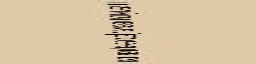

[0.05994686]


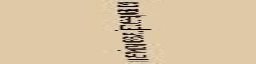

[0.03375866]


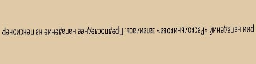

[4.7833673e-05]


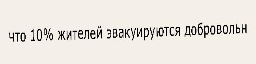

[2.575509e-05]


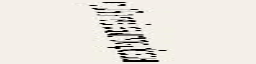

[0.4072876]


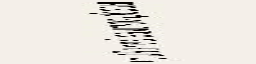

[0.44278762]


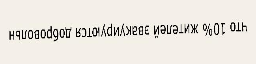

[3.7809954e-05]


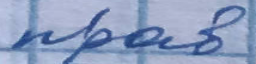

[1.]


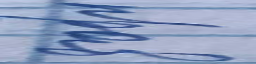

[1.]


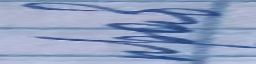

[1.]


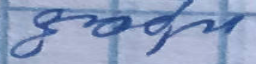

[1.]


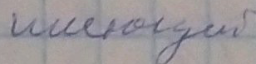

[0.9998852]


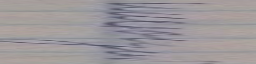

[0.9995634]


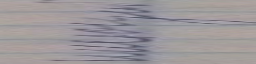

[0.999539]


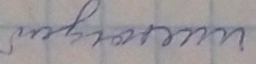

[0.99991536]


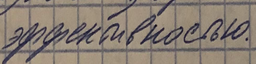

[1.]


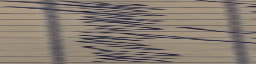

[0.5179336]


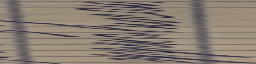

[0.5122806]


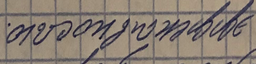

[1.]


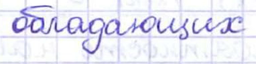

[1.]


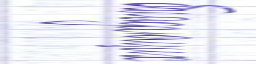

[0.99999976]


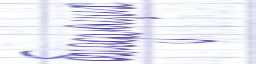

[0.99999964]


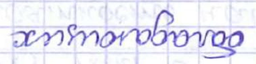

[1.]


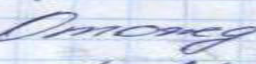

[1.]


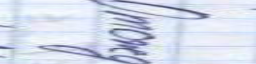

[0.99999833]


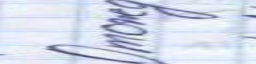

[0.9999968]


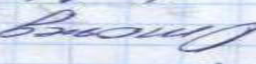

[1.]


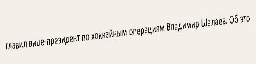

[9.120923e-08]


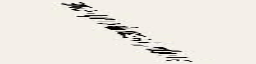

[0.26324764]


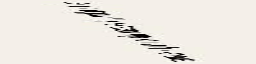

[0.33885676]


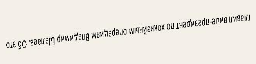

[4.9301107e-08]


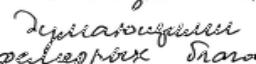

[1.]


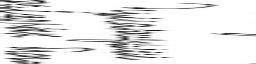

[0.00466883]


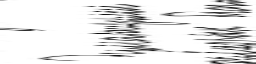

[0.00298489]


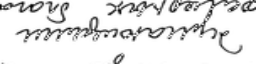

[1.]


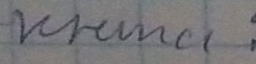

[0.9998336]


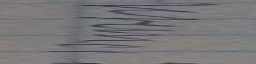

[0.9982083]


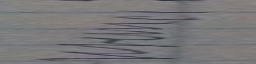

[0.99922013]


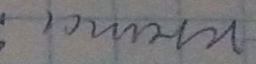

[0.99988234]


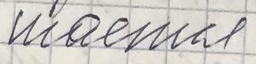

[1.]


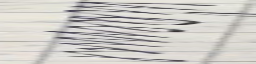

[0.9645899]


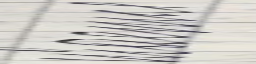

[0.94876134]


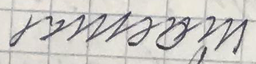

[1.]


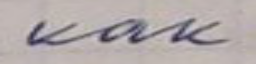

[0.9999987]


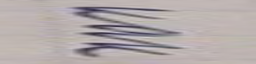

[0.9999883]


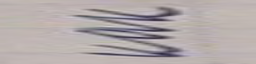

[0.9999989]


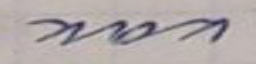

[0.99999917]


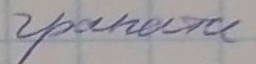

[0.99999976]


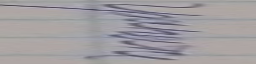

[0.999648]


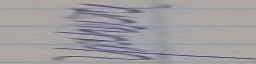

[0.99964464]


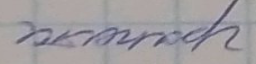

[0.9999999]


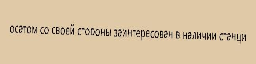

[3.2446718e-07]


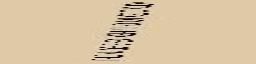

[0.00595597]


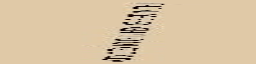

[0.00587289]


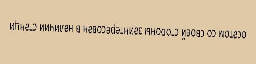

[3.6270984e-07]


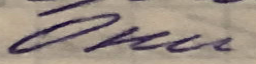

[1.]


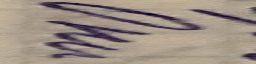

[0.9999989]


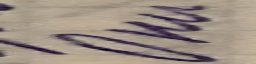

[0.9999995]


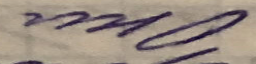

[1.]


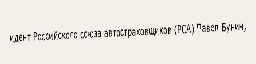

[3.0798249e-06]


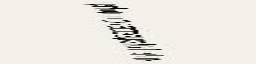

[0.25114763]


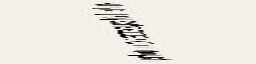

[0.12612158]


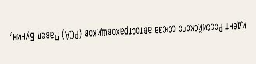

[2.2396994e-06]


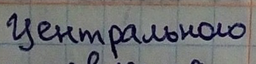

[1.]


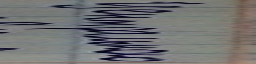

[0.9149189]


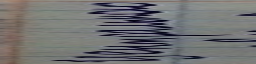

[0.961468]


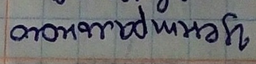

[1.]


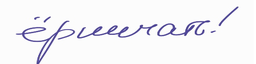

[1.]


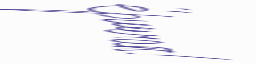

[0.9999968]


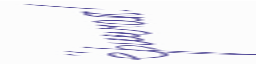

[0.99999857]


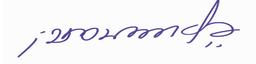

[1.]


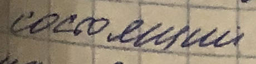

[1.]


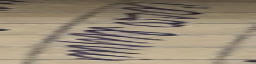

[0.9612471]


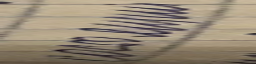

[0.8433676]


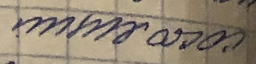

[1.]


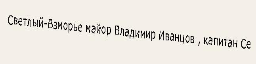

[4.6034124e-08]


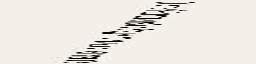

[0.20524742]


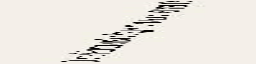

[0.18156423]


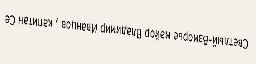

[5.4462376e-08]


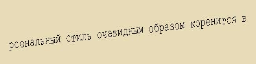

[0.00438738]


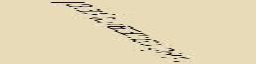

[0.00023294]


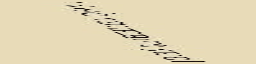

[0.00025684]


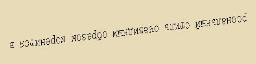

[0.00400187]


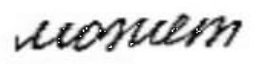

[1.]


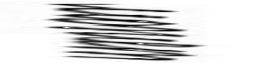

[1.]


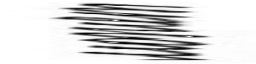

[1.]


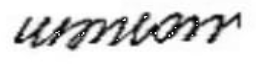

[1.]


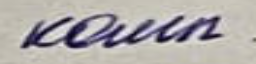

[1.]


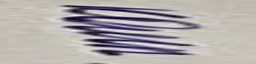

[1.]


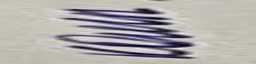

[1.]


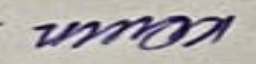

[1.]


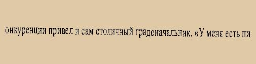

[1.1193662e-07]


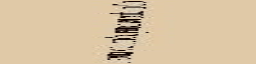

[0.8657536]


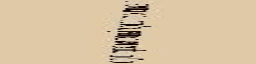

[0.84163374]


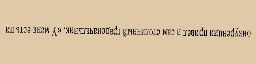

[1.1926414e-07]


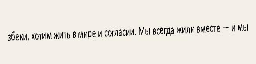

[1.1717813e-06]


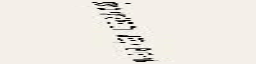

[0.10483835]


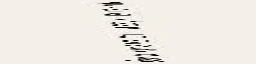

[0.12930441]


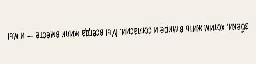

[9.0582205e-07]


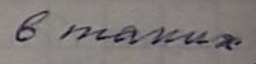

[1.]


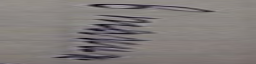

[0.6011588]


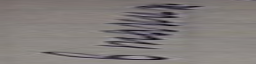

[0.64938307]


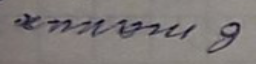

[0.9999999]


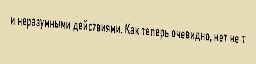

[3.0314582e-06]


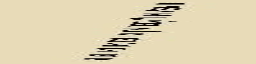

[0.3413034]


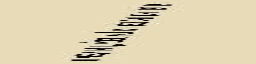

[0.248814]


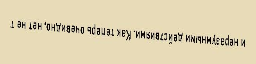

[2.3219195e-06]


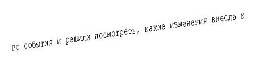

[0.01292088]


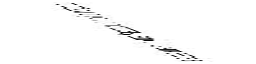

[0.2492039]


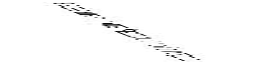

[0.1739357]


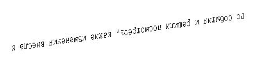

[0.01511293]


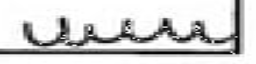

[1.]


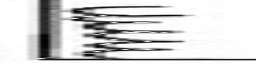

[0.9999113]


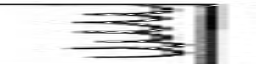

[0.9992441]


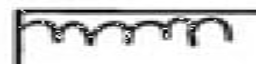

[1.]


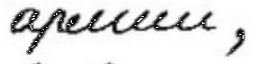

[1.]


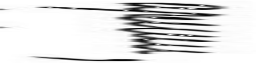

[0.9999771]


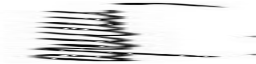

[0.99997747]


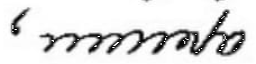

[1.]


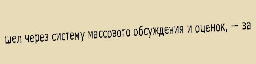

[1.2790682e-05]


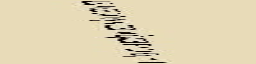

[0.00187642]


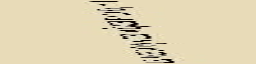

[0.00871601]


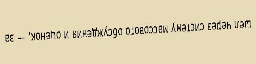

[1.3791611e-06]


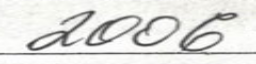

[1.]


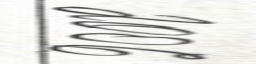

[0.99999917]


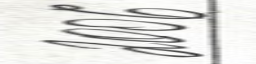

[0.99999976]


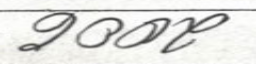

[1.]


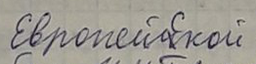

[1.]


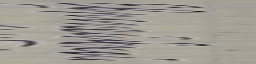

[0.3461415]


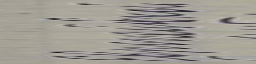

[0.27608895]


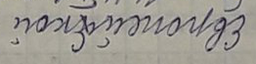

[1.]


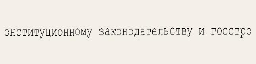

[0.00163523]


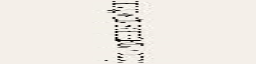

[0.04485729]


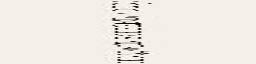

[0.01826986]


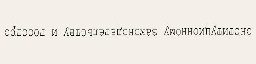

[0.00187086]


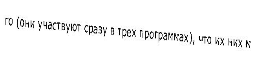

[7.045816e-05]


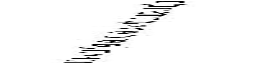

[0.01120667]


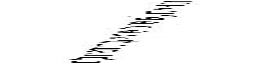

[0.00587421]


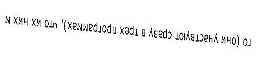

[0.00016706]


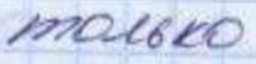

[1.]


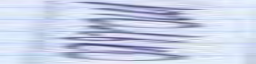

[0.99999976]


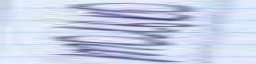

[1.]


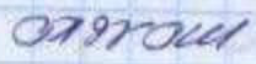

[1.]


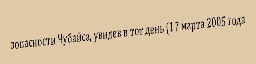

[7.2719155e-07]


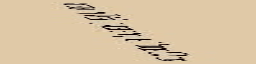

[6.964672e-05]


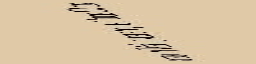

[0.00010752]


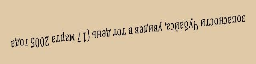

[1.4185462e-06]


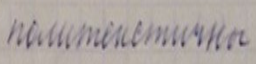

[0.9998171]


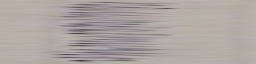

[0.9996877]


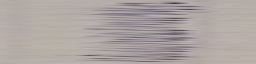

[0.9997403]


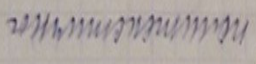

[0.99976283]


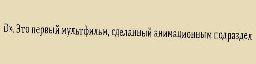

[2.235366e-08]


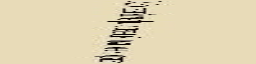

[0.1523904]


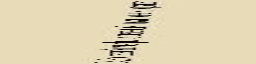

[0.1555444]


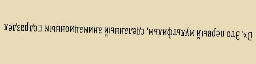

[1.7919307e-08]


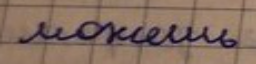

[1.]


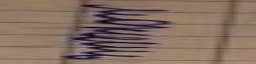

[0.87254703]


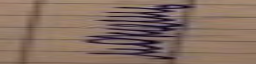

[0.87873197]


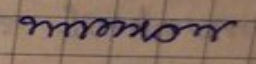

[1.]


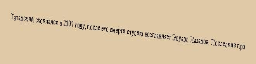

[0.00999112]


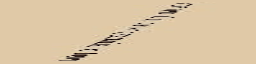

[0.11576812]


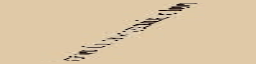

[0.12644254]


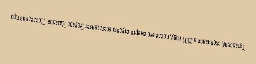

[0.01587402]


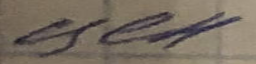

[0.9999993]


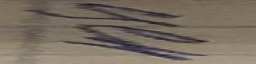

[0.99989676]


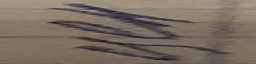

[0.99909246]


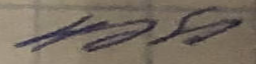

[0.99999905]


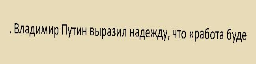

[5.202489e-08]


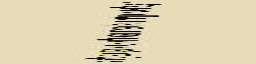

[0.30405697]


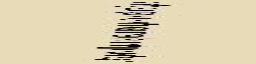

[0.45523748]


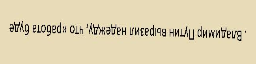

[2.4344618e-07]


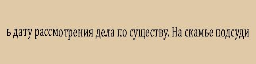

[3.1975472e-07]


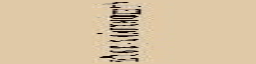

[0.42125553]


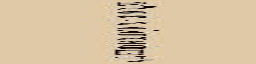

[0.61565906]


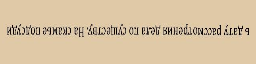

[4.245314e-07]


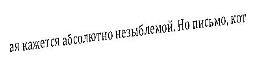

[1.7438746e-06]


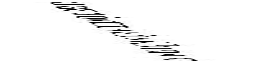

[0.00396086]


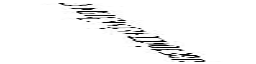

[0.00207612]


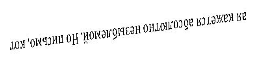

[1.7128546e-06]


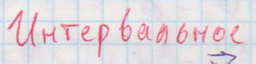

[0.9999782]


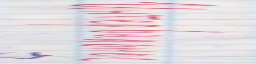

[0.99992585]


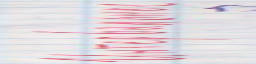

[0.99993455]


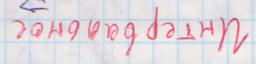

[0.99996805]


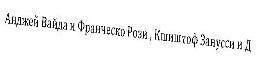

[1.436419e-09]


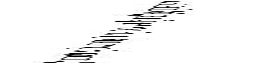

[0.00953955]


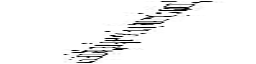

[0.06326687]


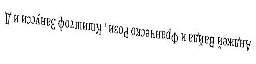

[1.0951382e-09]


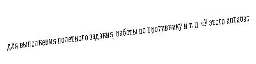

[5.6367433e-05]


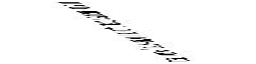

[0.42946255]


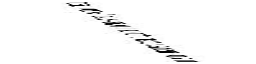

[0.45088688]


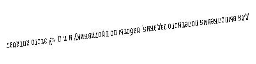

[8.546019e-05]


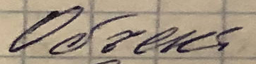

[1.]


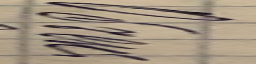

[0.76553327]


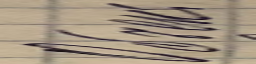

[0.7822369]


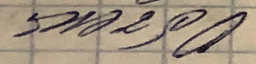

[1.]


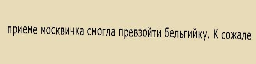

[6.947374e-08]


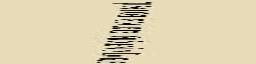

[0.464431]


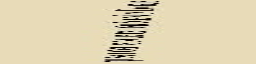

[0.11901973]


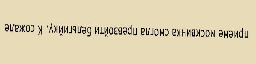

[1.2683354e-07]


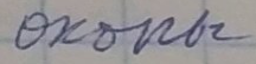

[1.]


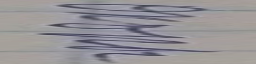

[0.9999285]


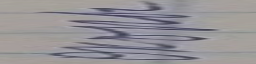

[0.99994326]


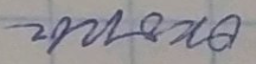

[1.]


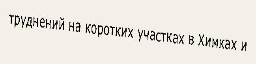

[0.00328273]


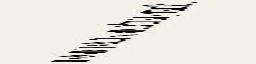

[0.93023604]


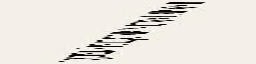

[0.9314566]


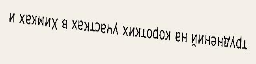

[0.00241472]


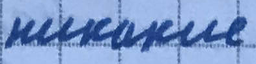

[1.]


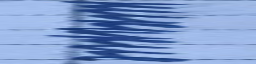

[1.]


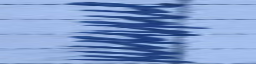

[1.]


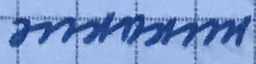

[1.]


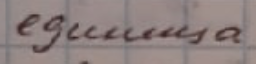

[0.9997149]


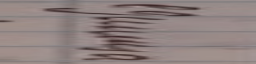

[0.99968827]


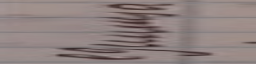

[0.9996939]


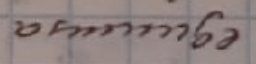

[0.99984896]


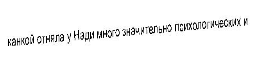

[3.161875e-05]


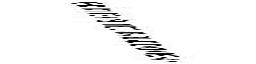

[0.95059896]


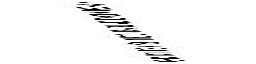

[0.9326708]


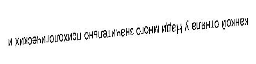

[1.5298683e-05]


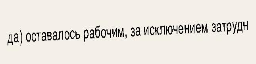

[0.00023645]


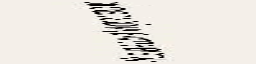

[0.95411056]


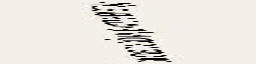

[0.90453774]


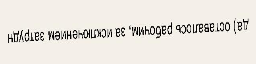

[0.00020018]


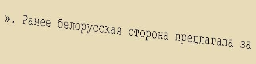

[0.00343553]


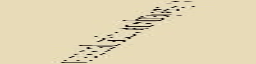

[0.00842351]


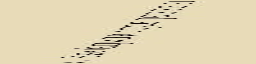

[0.00508895]


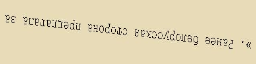

[0.00459403]


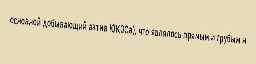

[1.4158996e-07]


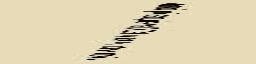

[0.9950984]


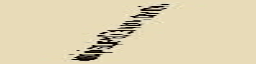

[0.9971942]


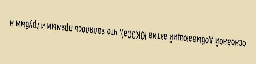

[6.076042e-08]


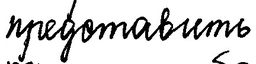

[1.]


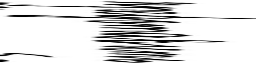

[1.]


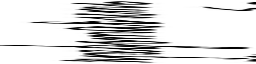

[1.]


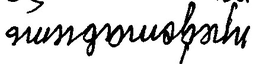

[1.]


In [ ]:
zf_test = zipfile.ZipFile('/content/drive/MyDrive/Task1/test.zip')
df_test = pd.read_csv(zf_test.open('test.csv'))

names = df["name"].values
label = df["label"].values[:100]
imgs = []
for i, n in enumerate(names[:100]):
    data = zf_imgs.read("imgs/"+n)
    img = cv2.imdecode(np.frombuffer(data, np.uint8), 1)
    img1 = cv2.resize(img, (256, 64))
    img2 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    img2 = cv2.resize(img2, (256, 64))
    img3 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img3 = cv2.resize(img3, (256, 64))
    img4 = cv2.rotate(img, cv2.ROTATE_180)
    img4 = cv2.resize(img4, (256, 64))
    imgs.append(img1)
    imgs.append(img2)
    imgs.append(img3)
    imgs.append(img4)

pred = model.predict(np.array(imgs))
j = 0
count_error = 0
for i, img in enumerate(imgs):
    cv2_imshow(img)
    print(pred[i])
    if i % 4 == 3:
        p = [pred[i-3], pred[i-2],
             pred[i-1], pred[i]]
        if sum(p) > 2:
            if label[j] != 1:
                print("Error")
                count_error += 1
        else:
            if label[j] != 0:
                print("Error")
                count_error += 1
        j += 1


Выводим количество ошибок предсказаний

In [ ]:
print(count_error)

0
